# EASEr

Based on https://arxiv.org/pdf/1905.03375v1.pdf by Harald Steck

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

### Cross Validation

In [2]:
def load_adjacency_matrix(path) -> np.ndarray:
    df = pd.read_csv(path)
    inc_df = df.Id.str.split("_", expand=True)
    inc_df.columns = ["user", "movie"]
    inc_df["rating"] = df.Prediction

    A = np.zeros((10000,1000), dtype=np.float32)
    users = inc_df["user"].apply(lambda x: int(x[1:])-1)
    movies = inc_df["movie"].apply(lambda x: int(x[1:])-1)
    ratings = inc_df["rating"]
    A[users, movies] = ratings

    return A


def run_EASEr(split=0, l2_reg=500):
    X_train = load_adjacency_matrix(f"../data/cross_validation/train_split_{split}.csv")
    X_test = load_adjacency_matrix(f"../data/cross_validation/test_split_{split}.csv")

    X_train[X_train == 0] = np.nan
    mu = np.nanmean(X_train, axis=0)
    s = np.nanstd(X_train, axis=0)
    s = np.ones_like(s)
    X_train = (X_train - mu) / s
    X_train = np.nan_to_num(X_train)

    # EASEr
    G = np.matmul(X_train.T, X_train)
    diagIndices = np.diag_indices(G.shape[0])
    G[diagIndices] += l2_reg
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    B[diagIndices] = 0

    S = np.matmul(X_train, B)

    S = S * s + mu
    X_train = X_train * s + mu

    # Compute RMSE
    train_rmse = np.sqrt(np.mean((S - X_train)[X_train.nonzero()]**2))
    valid_rmse = np.sqrt(np.mean((S - X_test)[X_test.nonzero()]**2))

    print(f"l2: {l2_reg:<4}, Split {split}, Train RMSE: {train_rmse:.3f}, Test RMSE: {valid_rmse:.3f}")

In [3]:
for i in range(5):
    run_EASEr(i)

l2: 500 , Split 0, Train RMSE: 0.294, Test RMSE: 1.015
l2: 500 , Split 1, Train RMSE: 0.294, Test RMSE: 1.014
l2: 500 , Split 2, Train RMSE: 0.293, Test RMSE: 1.016
l2: 500 , Split 3, Train RMSE: 0.294, Test RMSE: 1.013
l2: 500 , Split 4, Train RMSE: 0.294, Test RMSE: 1.014


### Submission

In [4]:
l2_reg = 500
X_train = load_adjacency_matrix("../data/data_train.csv")

X_train[X_train == 0] = np.nan
mu = np.nanmean(X_train, axis=0)
s = np.nanstd(X_train, axis=0)
s = np.ones_like(s)
X_train = (X_train - mu) / s
X_train = np.nan_to_num(X_train)

# EASEr
G = np.matmul(X_train.T, X_train)
diagIndices = np.diag_indices(G.shape[0])
G[diagIndices] += l2_reg
P = np.linalg.inv(G)
B = P / (-np.diag(P))
B[diagIndices] = 0

S = np.matmul(X_train, B)

pred = S * s + mu

sample_sub = pd.read_csv("../data/sampleSubmission.csv")
prediction = []
for cell_id in sample_sub.Id:
    row, col = cell_id.split("_")
    prediction.append(pred[int(row[1:])-1, int(col[1:])-1])
sample_sub.Prediction = prediction
sample_sub.to_csv("../data/easer.csv", index=False)
sample_sub

,Id,Prediction
0,r37_c1,3.310669
1,r73_c1,3.297220
2,r156_c1,3.476232
3,r160_c1,3.520969
4,r248_c1,3.313321
...,...,...
1176947,r9974_c1000,3.695198
1176948,r9977_c1000,3.787234
1176949,r9978_c1000,3.789125
1176950,r9982_c1000,3.589844


### Visualization

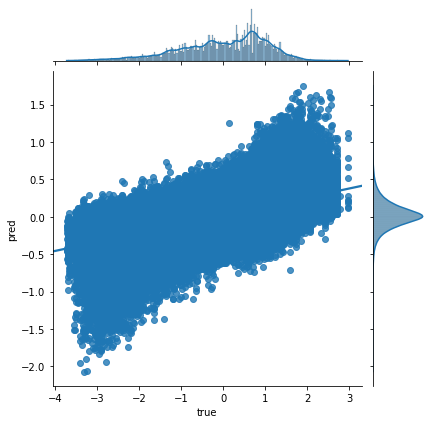

In [5]:
nonzero_ratings = pd.DataFrame({"true": X_train[X_train.nonzero()].flatten(), 
                                "pred": S[X_train.nonzero()].flatten()})

sns.jointplot(x="true", y="pred", data=nonzero_ratings, kind="reg", truncate=False)

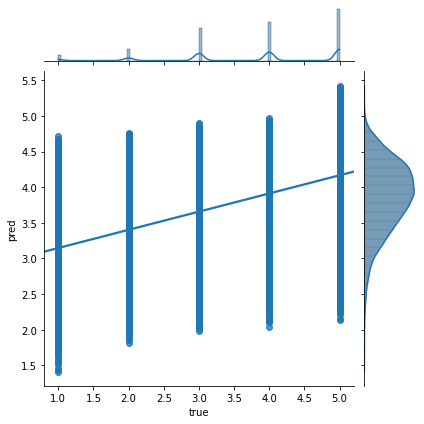

In [6]:
data_train = load_adjacency_matrix("../data/data_train.csv")

nonzero_ratings = pd.DataFrame({"true": data_train[data_train.nonzero()].flatten(), 
                                "pred": pred[data_train.nonzero()].flatten()})

sns.jointplot(x="true", y="pred", data=nonzero_ratings, kind="reg", truncate=False)